# **Attention Mechanism**

**Dolphins:** R. ARNAUD M. DELPLANQUE A. KARILA-COHEN A. RAMPOLDI

Comprehensive soil classification dataset: https://www.kaggle.com/datasets/ai4a-lab/comprehensive-soil-classification-datasets/code

### **1. Preliminnary tasks**

**1.1. Install and import the libraries**

In [2]:
#install the needed libraries
# pip install timm

In [3]:
# --- 1. Std libraries ---
import time
import copy
import numpy as np
import os

# --- 2. Graphs ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- 3. PyTorch ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# --- 4. Advanced Models (Swin Transformer) ---
import timm 

# --- 5. Metrics and Statistics (Scikit-Learn) ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

**1.2. Choose the good torch device**

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'xpu' if hasattr(torch, "xpu") and torch.xpu.is_available() else 'cpu'
print(f"Params loaded. Device: {DEVICE}")

Params loaded. Device: cuda


**1.3. General parameters**

In [ ]:
# General parameters
TRAIN_RATIO  = 0.7
VAL_RATIO    = 0.1
TEST_RATIO   = 0.2
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 10
LEARNING_RATE = 5e-5
NUM_CLASSES = 7

SEED = 42 # Important: we all use the SAME seed in the group!

current_path = os.getcwd()
DATA_DIR = os.path.join(current_path, '..', 'data', 'Orignal-Dataset')

### 2. Splitting the dataset

In [6]:
# --- 2. DATA TRANSFORMATIONS ---

# Train: Data Augmentation (No Black Borders Strategy)
train_transforms = transforms.Compose([
    # RandomResizedCrop replaces the standard Resize + Rotation approach.
    # - scale=(0.8, 1.0): Crops a random portion between 80% and 100% of the original image (Mild Zoom)
    # - ratio=(0.9, 1.1): Maintains aspect ratio close to square (prevents excessive distortion)
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    
    # Color and Lighting adjustments (Crucial for Soil Texture)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.01),
    
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # Note: RandomRotation was removed because RandomResizedCrop already provides geometric variation without creating artifacts
    
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Eval (Val/Test): Clean images, only resize and normalize
eval_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 3. DATA LOADING ---
# We create two instances of the dataset: one with augs, one without
full_data_train = datasets.ImageFolder(root=DATA_DIR, transform=train_transforms)
full_data_eval  = datasets.ImageFolder(root=DATA_DIR, transform=eval_transforms)

indices = list(range(len(full_data_train)))
targets = full_data_train.targets

# --- 4. SPLIT STRATEGY (Dynamic based on Ratios) ---

# PHASE 1: Split Training from the rest (Validation + Test)
# The size of "rest" is (1 - TRAIN_RATIO)
train_idx, rest_idx = train_test_split(
    indices, 
    test_size=(1 - TRAIN_RATIO), 
    random_state=SEED, 
    stratify=targets
)

# PHASE 2: Split the "Rest" into Validation and Test
# Logic: We need to find the proportion of Test set relative to the Rest.
# Example: If Val=0.1 and Test=0.2, then Rest=0.3.
# The Test portion inside Rest is 0.2 / 0.3 = 0.66 (2/3).
relative_test_size = TEST_RATIO / (VAL_RATIO + TEST_RATIO)

rest_targets = [targets[i] for i in rest_idx] # Targets for stratification
val_idx, test_idx = train_test_split(
    rest_idx, 
    test_size=relative_test_size, 
    random_state=SEED, 
    stratify=rest_targets
)

# --- 5. SUBSETS & DATALOADERS ---
train_dataset = Subset(full_data_train, train_idx)
val_dataset   = Subset(full_data_eval, val_idx)
test_dataset  = Subset(full_data_eval, test_idx)

# Note: num_workers=0 is safer on Windows to avoid BrokenPipeError. Change to 2 if on Linux/Colab.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# --- 6. VERIFICATION ---
total = len(indices)
print(f"Data Loaded Successfully!")
print(f"Total Images: {total}")
print(f"Training Set:   {len(train_dataset)} images ({len(train_dataset)/total:.2%}) -> Target: {TRAIN_RATIO*100}%")
print(f"Validation Set: {len(val_dataset)} images ({len(val_dataset)/total:.2%}) -> Target: {VAL_RATIO*100}%")
print(f"Test Set:       {len(test_dataset)} images ({len(test_dataset)/total:.2%}) -> Target: {TEST_RATIO*100}%")
print(f"Classes found: {full_data_train.classes}")

Data Loaded Successfully!
Total Images: 1189
Training Set:   832 images (69.97%) -> Target: 70.0%
Validation Set: 119 images (10.01%) -> Target: 10.0%
Test Set:       238 images (20.02%) -> Target: 20.0%
Classes found: ['Alluvial_Soil', 'Arid_Soil', 'Black_Soil', 'Laterite_Soil', 'Mountain_Soil', 'Red_Soil', 'Yellow_Soil']


### 3. Simple data augmentation


Visualizing dataset samples...


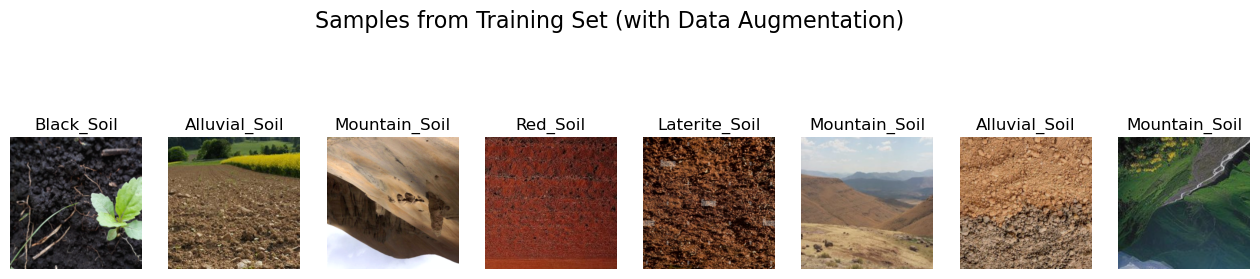

In [7]:
# Function to display a batch of images
def show_dataset_samples(loader, class_names):
    # Get a batch of images from the DataLoader
    images, labels = next(iter(loader))
    
    # Take only the first 8 images to avoid a huge plot
    images = images[:8]
    labels = labels[:8]

    # Create a grid
    plt.figure(figsize=(16, 4))
    
    # Denormalization to visualize real colors
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    for i in range(len(images)):
        ax = plt.subplot(1, 8, i + 1)
        # Convert tensor to numpy and transpose dimensions (C, H, W) -> (H, W, C)
        img = images[i].numpy().transpose((1, 2, 0))
        
        # Apply inverse normalization
        img = std * img + mean
        
        # Clip values to be between 0 and 1 to avoid display errors
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")
    
    plt.suptitle("Samples from Training Set (with Data Augmentation)", fontsize=16)
    plt.show()

# Run the function using your train_loader
print("Visualizing dataset samples...")
show_dataset_samples(train_loader, full_data_train.classes)

### 4. model training

In [9]:
# --- 1. SETUP ---

# Device check (GPU vs CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cpu':
    print("WARNING: You are using the CPU. Training will be slow (half an hour or more).")
else:
    print("GOOD: GPU detected. Training will be fast.")

# --- 2. LOADING SWIN TRANSFORMER MODEL ---
print("\nDownloading and preparing Swin Transformer...")
# We use the 'tiny' version which is lightweight but powerful
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=NUM_CLASSES)
model = model.to(device)

from sklearn.utils.class_weight import compute_class_weight

# --- 3. TRAINING SETUP WITH CLASS BALANCING ---

print("Calculating class weights to handle Class Imbalance...")

# 1. Extract labels ONLY from the Training Set indices
# We need to calculate weights based on what the model actually sees during training
train_labels = [full_data_train.targets[i] for i in train_idx]

# 2. Compute weights (Inverse Frequency)
# The 'balanced' mode automatically calculates: n_samples / (n_classes * np.bincount(y))
# Rarer classes (like Alluvial Soil) get higher weights; frequent classes get lower weights.
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_labels), 
    y=train_labels
)

# 3. Convert to PyTorch Tensor and move to GPU/CPU
# It is crucial to cast to float and send to the same device as the model
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Computed Class Weights: {class_weights}")
print("Note: Higher values indicate rarer classes (the model will be penalized more for missing them).")

# 4. Loss Function & Optimizer
# We pass the weights to CrossEntropyLoss to enforce the balancing strategy
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer: AdamW is standard for Transformers
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# Scheduler: Decay LR by a factor of 0.1 every 5 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# --- 4. TRAINING LOOP (The engine) ---
print(f"\nStarting training on {len(train_loader.dataset)} images...")
start_time_global = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(EPOCHS):
    epoch_start = time.time()
    print(f'\nEpoch {epoch+1}/{EPOCHS}')
    print('-' * 10)

    # --- TRAIN PHASE ---
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 1. Zero the gradients
        optimizer.zero_grad()

        # 2. Forward pass (Prediction)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 3. Backward pass (Learning)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()  # Update learning rate
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total

    # --- VALIDATION PHASE ---
    model.eval()   # Set model to evaluation mode (no dropout)
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # No gradient computation (saves memory and time)
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Compute loss for validation

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / val_total

    epoch_time = time.time() - epoch_start

    # --- EPOCH REPORT ---
    print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"Epoch Time: {epoch_time:.1f}s")

    # --- SAVE BEST MODEL ---
    # If validation accuracy improves, save this model version
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), os.path.join(current_path, '..', 'src', 'best_swin_model.pth'))
        print("Improvement detected. Model saved.")

total_time = time.time() - start_time_global
print(f'\nTraining completed in {total_time // 60:.0f}m {total_time % 60:.0f}s')
print(f'Best Validation Accuracy achieved: {best_acc:.2f}%')

# Reload the best weights into the model before exiting
model.load_state_dict(best_model_wts)


Using device: cuda
GOOD: GPU detected. Training will be fast.

Calculating class weights to handle Class Imbalance...
Computed Class Weights: tensor([3.3016, 0.5973, 0.6640, 0.7768, 0.8430, 1.5639, 2.4762],
       device='cuda:0')
Note: Higher values indicate rarer classes (the model will be penalized more for missing them).

Starting training on 832 images...

Epoch 1/10
----------
Train Loss: 1.2913 | Train Acc: 59.74%
Val Loss:   0.8233 | Val Acc:   86.55%
Epoch Time: 21.5s
Improvement detected. Model saved.

Epoch 2/10
----------
Train Loss: 0.4643 | Train Acc: 86.42%
Val Loss:   0.5794 | Val Acc:   84.03%
Epoch Time: 20.5s

Epoch 3/10
----------
Train Loss: 0.2890 | Train Acc: 90.38%
Val Loss:   0.7288 | Val Acc:   91.60%
Epoch Time: 21.3s
Improvement detected. Model saved.

Epoch 4/10
----------
Train Loss: 0.2015 | Train Acc: 93.27%
Val Loss:   0.6957 | Val Acc:   92.44%
Epoch Time: 22.1s
Improvement detected. Model saved.

Epoch 5/10
----------
Train Loss: 0.1275 | Train Acc: 9

<All keys matched successfully>

### 5. Results analysis


C:\Users\alera\AppData\Local\Temp\ipykernel_3820\3847282609.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(current_path, '

Evaluating on the TEST SET...

FINAL CLASSIFICATION REPORT
               precision    recall  f1-score   support

Alluvial_Soil     0.7000    0.7000    0.7000        10
    Arid_Soil     0.8929    0.8772    0.8850        57
   Black_Soil     0.9615    0.9804    0.9709        51
Laterite_Soil     0.9706    0.7500    0.8462        44
Mountain_Soil     0.8889    1.0000    0.9412        40
     Red_Soil     0.8148    1.0000    0.8980        22
  Yellow_Soil     1.0000    1.0000    1.0000        14

     accuracy                         0.9076       238
    macro avg     0.8898    0.9011    0.8916       238
 weighted avg     0.9123    0.9076    0.9058       238



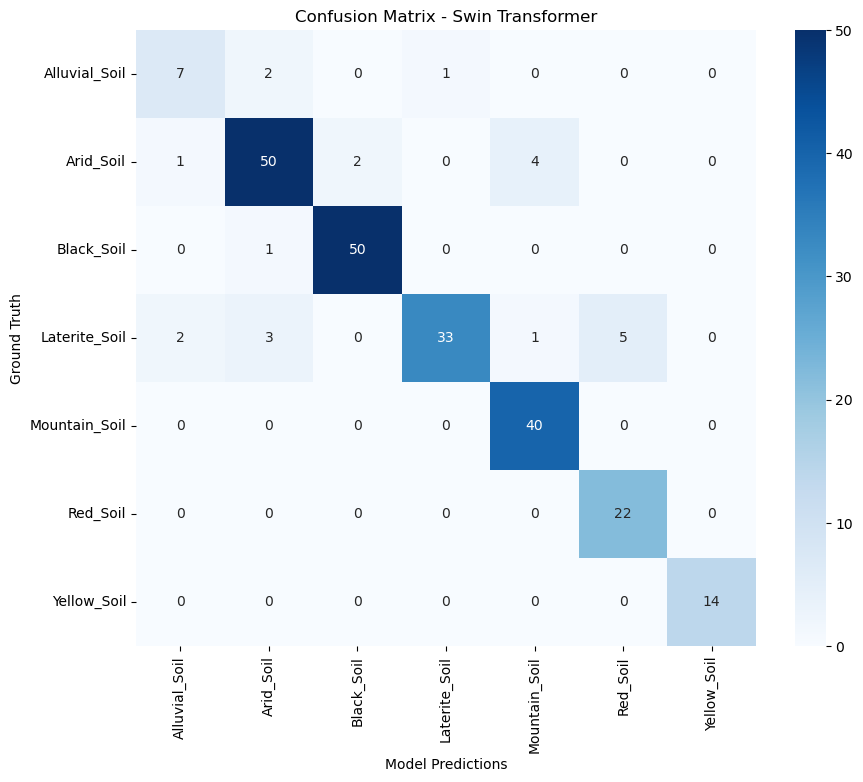

In [10]:
# 1. Load the best weights from training
model.load_state_dict(torch.load(os.path.join(current_path, '..', 'src', 'best_swin_model.pth')))
model.eval()  # Evaluation mode
model.to(device)

print("Evaluating on the TEST SET...")

y_true = []
y_pred = []

# 2. Get predictions
with torch.no_grad():
    for inputs, labels in test_loader:  # Note: we are using test_loader now
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Retrieve class names
class_names = full_data_train.classes

# --- 3. CLASSIFICATION REPORT (Exact metrics) ---
print("\n" + "=" * 50)
print("FINAL CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# --- 4. CONFUSION MATRIX (Plot) ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Model Predictions')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix - Swin Transformer')
plt.show()


### 6. Specific errors analysis

In [ ]:
# Function to properly restore image colors (always needed)
def imshow_denorm(img, ax):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')

# --- CONFIGURATION ---
TARGET_CLASS = "Alluvial_Soil"  # The class we want to analyze
try:
    target_idx = class_names.index(TARGET_CLASS)
except ValueError:
    print(f"Error: '{TARGET_CLASS}' not found in the class list. Check the spelling.")
    print(f"Available classes: {class_names}")
    target_idx = -1

# --- SEARCH FOR CLASS-SPECIFIC ERRORS ---
if target_idx != -1:
    model.eval()
    specific_errors = []
    
    print(f"Looking for misclassifications related to: {TARGET_CLASS}...")

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                # Filtering logic:
                # 1. The image truly belongs to Alluvial Soil (labels[i] == target_idx)
                # 2. The model made a mistake (preds[i] != labels[i])
                if labels[i] == target_idx and preds[i] != labels[i]:
                    specific_errors.append({
                        'img': inputs[i],
                        'pred': class_names[preds[i]]  # What the model predicted instead
                    })

    print(f"Found {len(specific_errors)} errors for {TARGET_CLASS}.")

    # --- VISUALIZATION ---
    if len(specific_errors) > 0:
        cols = 3  # Number of columns
        rows = (len(specific_errors) // cols) + 1
        plt.figure(figsize=(15, rows * 4))
        
        plt.suptitle(f"Error Analysis: {TARGET_CLASS}", fontsize=16, y=1.02)

        for idx, error in enumerate(specific_errors):
            ax = plt.subplot(rows, cols, idx + 1)
            imshow_denorm(error['img'], ax)
            
            # Clear, descriptive title
            ax.set_title(
                f"True class: {TARGET_CLASS}\nPredicted: {error['pred']}",
                color='red',
                fontsize=12,
                fontweight='bold'
            )
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No errors found for {TARGET_CLASS}. The model performs perfectly on this class.")


NameError: name 'class_names' is not defined